<a href="https://colab.research.google.com/github/malcolmrite-dsi/CPT-House-Predictions/blob/master/Data_Cleaning_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Libraries

In [ ]:
#Importing libraries for cleaning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Importing Training and Test Data

In [ ]:
#Using Pandas Library to import training data
train_data = pd.read_csv("drive/My Drive/Train.csv")

#Using Pandas Library to import test data
test_data = pd.read_csv("drive/My Drive/Test.csv")

# Missing Values Code

In [ ]:
train_data.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,1/6/2019,F,M,1981,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,1/6/2013,M,U,1991,748L,QZYX,90QI,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2S9E81J,1/8/2019,M,M,1990,1X1H,BP09,56SI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,BHDYVFT,1/8/2019,M,M,1990,748L,NO3L,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [ ]:
train_data['join_date']

0         1/2/2019
1         1/6/2019
2         1/6/2013
3         1/8/2019
4         1/8/2019
           ...    
29127     1/9/2019
29128    1/11/2018
29129     1/2/2019
29130     1/7/2019
29131     1/3/2020
Name: join_date, Length: 29132, dtype: object

In [ ]:
#Check Missing Values in a Dataset
def NACount(data):
  NaCount = {}
  for feature in data.columns:
    NaCount[feature] = data[feature].isna().sum()

  return NaCount

In [ ]:
#Produce Missing Values array in a Dataset
def NaArray(data):
  NaCount = {}
  for feature in data.columns:
    NaCount[feature] = data[feature].isna()

  return NaArray

In [ ]:
#Check Unique Values in Training Data
def UniqueCount(data):
  UnCount = {}
  for feature in data.columns:
    UnCount[feature] = data[feature].unique()

  return UnCount

In [ ]:
#Run Function on training Data

print(NACount(train_data))

{'ID': 0, 'join_date': 2, 'sex': 0, 'marital_status': 0, 'birth_year': 0, 'branch_code': 0, 'occupation_code': 0, 'occupation_category_code': 0, 'P5DA': 0, 'RIBP': 0, '8NN1': 0, '7POT': 0, '66FJ': 0, 'GYSR': 0, 'SOP4': 0, 'RVSZ': 0, 'PYUQ': 0, 'LJR9': 0, 'N2MW': 0, 'AHXO': 0, 'BSTQ': 0, 'FM3X': 0, 'K6QO': 0, 'QBOL': 0, 'JWFN': 0, 'JZ9D': 0, 'J9JW': 0, 'GHYX': 0, 'ECY3': 0}


In [ ]:
#Run Function on test Data

print(NACount(test_data))

{'ID': 0, 'join_date': 1, 'sex': 0, 'marital_status': 0, 'birth_year': 0, 'branch_code': 0, 'occupation_code': 0, 'occupation_category_code': 0, 'P5DA': 0, 'RIBP': 0, '8NN1': 0, '7POT': 0, '66FJ': 0, 'GYSR': 0, 'SOP4': 0, 'RVSZ': 0, 'PYUQ': 0, 'LJR9': 0, 'N2MW': 0, 'AHXO': 0, 'BSTQ': 0, 'FM3X': 0, 'K6QO': 0, 'QBOL': 0, 'JWFN': 0, 'JZ9D': 0, 'J9JW': 0, 'GHYX': 0, 'ECY3': 0}


In [ ]:
#Run Unique Values Function on test Data

print(UniqueCount(test_data))

{'ID': array(['F86J5PC', 'H6141K3', 'RBAYUXZ', ..., '42WTEGT', '8EKC4O9',
       'WHII93K'], dtype=object), 'join_date': array(['1/12/2018', '1/10/2019', '1/1/2020', '1/2/2019', '1/2/2020',
       '1/5/2020', '1/5/2015', '1/6/2013', '1/1/2017', '1/1/2019',
       '1/7/2018', '1/6/2020', '1/4/2020', '1/12/2019', '1/3/2013',
       '1/5/2018', '1/1/2018', '1/10/2017', '1/8/2019', '1/4/2017',
       '1/9/2019', '1/7/2014', '1/3/2019', '1/6/2011', '1/4/2019',
       '1/11/2019', '1/9/2018', '1/12/2017', '1/5/2017', '1/3/2017',
       '1/1/2015', '1/9/2016', '1/7/2012', '1/5/2019', '1/7/2016',
       '1/8/2016', '1/2/2018', '1/10/2013', '1/3/2012', '1/5/2011',
       '1/6/2017', '1/7/2017', '1/12/2014', '1/10/2018', '1/11/2016',
       '1/8/2018', '1/7/2019', '1/8/2014', '1/7/2015', '1/10/2016',
       '1/3/2018', '1/8/2017', '1/1/2011', '1/4/2018', '1/3/2020',
       '1/6/2019', '1/2/2017', '1/6/2018', '1/9/2017', '1/4/2013',
       '1/8/2012', '1/4/2016', '1/11/2015', '1/3/2016', '1/12/20

In [ ]:
#Run  Unique Values Function on training Data

print(UniqueCount(train_data))

{'ID': array(['4WKQSBB', 'CP5S02H', '2YKDILJ', ..., 'MVXG2LC', 'BUQ8DQN',
       'DEJBWYU'], dtype=object), 'join_date': array(['1/2/2019', '1/6/2019', '1/6/2013', '1/8/2019', '1/9/2010',
       '1/9/2019', '1/5/2017', '1/5/2018', '1/11/2018', '1/10/2015',
       '1/1/2019', '1/2/2017', '1/8/2018', '1/7/2017', '1/6/2020',
       '1/3/2016', '1/6/2017', '1/11/2019', '1/6/2018', '1/5/2019',
       '1/10/2018', '1/11/2017', '1/3/2020', '1/1/2020', '1/11/2016',
       '1/10/2019', '1/4/2018', '1/4/2019', '1/4/2020', '1/2/2018',
       '1/3/2019', '1/8/2013', '1/7/2019', '1/11/2011', '1/1/2015',
       '1/4/2014', '1/4/2017', '1/8/2016', '1/12/2017', '1/12/2018',
       '1/7/2016', '1/5/2020', '1/1/2017', '1/7/2018', '1/10/2016',
       '1/12/2019', '1/10/2017', '1/10/2014', '1/9/2018', '1/1/2018',
       '1/2/2020', '1/7/2010', '1/7/2012', '1/9/2015', '1/9/2017',
       '1/3/2018', '1/7/2020', '1/7/2014', '1/3/2017', '1/6/2015',
       '1/6/2014', '1/1/2014', '1/12/2016', '1/1/2016', '1/8/

In [ ]:
#Drop the two records with missing join dates
train_data.dropna(inplace = True)
print(NACount(train_data))

{'ID': 0, 'join_date': 0, 'sex': 0, 'marital_status': 0, 'birth_year': 0, 'branch_code': 0, 'occupation_code': 0, 'occupation_category_code': 0, 'P5DA': 0, 'RIBP': 0, '8NN1': 0, '7POT': 0, '66FJ': 0, 'GYSR': 0, 'SOP4': 0, 'RVSZ': 0, 'PYUQ': 0, 'LJR9': 0, 'N2MW': 0, 'AHXO': 0, 'BSTQ': 0, 'FM3X': 0, 'K6QO': 0, 'QBOL': 0, 'JWFN': 0, 'JZ9D': 0, 'J9JW': 0, 'GHYX': 0, 'ECY3': 0}


In [ ]:
test_data.fillna('2018-11-08', inplace=True)

In [ ]:
#Drop the one record with a missing join date from the Test Data
test_data.dropna(inplace = True)
print(NACount(train_data))

{'ID': 0, 'join_date': 0, 'sex': 0, 'marital_status': 0, 'birth_year': 0, 'branch_code': 0, 'occupation_code': 0, 'occupation_category_code': 0, 'P5DA': 0, 'RIBP': 0, '8NN1': 0, '7POT': 0, '66FJ': 0, 'GYSR': 0, 'SOP4': 0, 'RVSZ': 0, 'PYUQ': 0, 'LJR9': 0, 'N2MW': 0, 'AHXO': 0, 'BSTQ': 0, 'FM3X': 0, 'K6QO': 0, 'QBOL': 0, 'JWFN': 0, 'JZ9D': 0, 'J9JW': 0, 'GHYX': 0, 'ECY3': 0}


In [ ]:
#Replacing little f with big F
train_data.marital_status.replace(["f"], ["F"], inplace = True)

In [ ]:
print(NACount(test_data))

{'ID': 0, 'join_date': 0, 'sex': 0, 'marital_status': 0, 'birth_year': 0, 'branch_code': 0, 'occupation_code': 0, 'occupation_category_code': 0, 'P5DA': 0, 'RIBP': 0, '8NN1': 0, '7POT': 0, '66FJ': 0, 'GYSR': 0, 'SOP4': 0, 'RVSZ': 0, 'PYUQ': 0, 'LJR9': 0, 'N2MW': 0, 'AHXO': 0, 'BSTQ': 0, 'FM3X': 0, 'K6QO': 0, 'QBOL': 0, 'JWFN': 0, 'JZ9D': 0, 'J9JW': 0, 'GHYX': 0, 'ECY3': 0}


# Data Type Checking

In [ ]:
def catDataType(data):
  for feature in data.columns:
    if data[feature].dtype == "object" and feature != "ID":
      data[feature] = data[feature].astype('category')

  return data



In [ ]:
#Check the data types of the training data
train_data.dtypes

ID                          object
join_date                   object
sex                         object
marital_status              object
birth_year                   int64
branch_code                 object
occupation_code             object
occupation_category_code    object
P5DA                         int64
RIBP                         int64
8NN1                         int64
7POT                         int64
66FJ                         int64
GYSR                         int64
SOP4                         int64
RVSZ                         int64
PYUQ                         int64
LJR9                         int64
N2MW                         int64
AHXO                         int64
BSTQ                         int64
FM3X                         int64
K6QO                         int64
QBOL                         int64
JWFN                         int64
JZ9D                         int64
J9JW                         int64
GHYX                         int64
ECY3                

In [ ]:
#Check the data types of the test data
test_data.dtypes

ID                          object
join_date                   object
sex                         object
marital_status              object
birth_year                   int64
branch_code                 object
occupation_code             object
occupation_category_code    object
P5DA                         int64
RIBP                         int64
8NN1                         int64
7POT                         int64
66FJ                         int64
GYSR                         int64
SOP4                         int64
RVSZ                         int64
PYUQ                         int64
LJR9                         int64
N2MW                         int64
AHXO                         int64
BSTQ                         int64
FM3X                         int64
K6QO                         int64
QBOL                         int64
JWFN                         int64
JZ9D                         int64
J9JW                         int64
GHYX                         int64
ECY3                

In [ ]:
cut_bins = [1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2020]
train_data['birth_year'] = pd.cut(train_data['birth_year'], bins=cut_bins)
test_data['birth_year'] = pd.cut(test_data['birth_year'], bins=cut_bins)

In [ ]:
#Convert the join date to datetime
train_data['join_date'] = pd.to_datetime(train_data['join_date'])
test_data['join_date'] = pd.to_datetime(test_data['join_date'])
train_data.dtypes

ID                                  object
join_date                   datetime64[ns]
sex                                 object
marital_status                      object
birth_year                        category
branch_code                         object
occupation_code                     object
occupation_category_code            object
P5DA                                 int64
RIBP                                 int64
8NN1                                 int64
7POT                                 int64
66FJ                                 int64
GYSR                                 int64
SOP4                                 int64
RVSZ                                 int64
PYUQ                                 int64
LJR9                                 int64
N2MW                                 int64
AHXO                                 int64
BSTQ                                 int64
FM3X                                 int64
K6QO                                 int64
QBOL       

In [ ]:

train_data['join_date'], bins_jd = pd.cut(train_data['join_date'], bins=8, retbins=True)
test_data['join_date'] = pd.cut(test_data['join_date'], bins = bins_jd)

In [ ]:
train_data.join_date.value_counts()

(2018-10-08 03:00:00, 2020-01-08]             12062
(2017-07-08 06:00:00, 2018-10-08 03:00:00]     7352
(2016-04-07 09:00:00, 2017-07-08 06:00:00]     4415
(2015-01-06 12:00:00, 2016-04-07 09:00:00]     2570
(2013-10-06 15:00:00, 2015-01-06 12:00:00]     1198
(2012-07-06 18:00:00, 2013-10-06 15:00:00]      615
(2011-04-06 21:00:00, 2012-07-06 18:00:00]      530
(2010-01-01 08:16:48, 2011-04-06 21:00:00]      388
Name: join_date, dtype: int64

In [ ]:
#Convert the categorial features into the category data type
train_data = catDataType(train_data)
test_data = catDataType(test_data)
train_data.dtypes

ID                            object
join_date                   category
sex                         category
marital_status              category
birth_year                  category
branch_code                 category
occupation_code             category
occupation_category_code    category
P5DA                           int64
RIBP                           int64
8NN1                           int64
7POT                           int64
66FJ                           int64
GYSR                           int64
SOP4                           int64
RVSZ                           int64
PYUQ                           int64
LJR9                           int64
N2MW                           int64
AHXO                           int64
BSTQ                           int64
FM3X                           int64
K6QO                           int64
QBOL                           int64
JWFN                           int64
JZ9D                           int64
J9JW                           int64
G

In [ ]:
test_data.join_date.value_counts()

(2018-10-08 03:00:00, 2020-01-08]             4150
(2017-07-08 06:00:00, 2018-10-08 03:00:00]    2476
(2016-04-07 09:00:00, 2017-07-08 06:00:00]    1516
(2015-01-06 12:00:00, 2016-04-07 09:00:00]     921
(2013-10-06 15:00:00, 2015-01-06 12:00:00]     396
(2012-07-06 18:00:00, 2013-10-06 15:00:00]     222
(2011-04-06 21:00:00, 2012-07-06 18:00:00]     173
(2010-01-01 08:16:48, 2011-04-06 21:00:00]     146
Name: join_date, dtype: int64

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29130 entries, 0 to 29131
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ID                        29130 non-null  object  
 1   join_date                 29130 non-null  category
 2   sex                       29130 non-null  category
 3   marital_status            29130 non-null  category
 4   birth_year                29130 non-null  category
 5   branch_code               29130 non-null  category
 6   occupation_code           29130 non-null  category
 7   occupation_category_code  29130 non-null  category
 8   P5DA                      29130 non-null  int64   
 9   RIBP                      29130 non-null  int64   
 10  8NN1                      29130 non-null  int64   
 11  7POT                      29130 non-null  int64   
 12  66FJ                      29130 non-null  int64   
 13  GYSR                      29130 non-null  int6

# Exploratory Data Analysis Function

In [ ]:
#Importing the graphing libraries
import matplotlib.pyplot as plt 
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Defining graphing function
def ExploreGraphs(x_feature, y_result, df, choice, custom):
  
  #Setting the visual features of the graph
  sns.set_style("darkgrid")
  plt.figure(figsize=(10,10))
  
  #Bar Chart choice
  if choice == "bar":

    barplot = sns.barplot(x = x_feature, y = y_result, data = df, ci=custom)
    plt.show()

  #Histogram choice
  elif choice == "hist":

    histplot = plt.hist(x = df[x_feature])
    plt.show()

  #Count Plot Choice
  elif choice == "count":

    barplot = sns.countplot(x = x_feature, data = df)
    plt.show()

  #Heat map choice
  elif choice == "heat":

    plt.figure(figsize=(30,30))
    sns.heatmap(df.corr(), vmax=0.8, square=True, annot = True)

  #Pair plot choice
  elif choice == "pair":

    sns.pairplot(df)

  #In case the choice input is not defined in the function
  else:
    print("Not a valid choice")

# Graphing Area

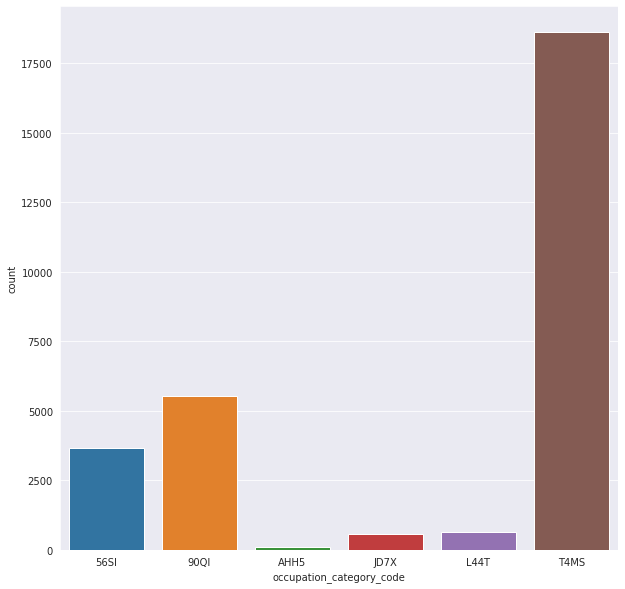

In [ ]:
'''
How to use function
FIRST PARAMETER: X Feature (Pandas Column Name)

SECOND PARAMETER: Y FEATURE (Pandas Column Name)

THIRD PARAMETER: DATA (Pandas Dataframe)

FOURTH PARAMETER: Choice of graph: "bar" for Bar Plot (Good for comparing one insurance product with a feature),
                                    "hist" for Histogram (Good for continuous distrbution of one feature),
                                    "count" for a count plot (Good for the discontinuous distribution of one feature),
                                    "heat" for a heatmap between the variables of the dataset,
                                    "pair" for a pairplot between the variables of a dataset (Be careful of the number of features you're comparing)

FIFTH PARAMETER: Confidence Interval error bar for Bar Plot = number (number% Confidence Interval), None (No error bar) 
'''
ExploreGraphs("occupation_category_code", "RVSZ", train_data, "count", 95)

# Feature Engineering

In [ ]:
def labelEncoder(data):
  for feature in data.columns:
    if feature == "occupation_code" and feature == "occupation_code":
      data[feature] = data[feature].astype('category')

  return data

In [ ]:
#Creating a copy of the features
train_data_features = train_data.iloc[:,1:8]
test_data_features = test_data.iloc[:,1:8]


In [ ]:
#Creating a copy of the products
train_data_products = train_data.iloc[:,8:]
test_data_products = test_data.iloc[:,8:]
test_data_products.head()

,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
test_data.birth_year.value_counts()

(1980, 1990]    3751
(1970, 1980]    3155
(1960, 1970]    1580
(1990, 2000]    1241
(1950, 1960]     265
(2000, 2020]       4
(1940, 1950]       2
(1930, 1940]       2
Name: birth_year, dtype: int64

In [ ]:
train_data_features.drop(columns = 'occupation_code', inplace = True)
test_data_features.drop(columns = 'occupation_code', inplace = True)
test_data_features

,join_date,sex,marital_status,birth_year,branch_code,occupation_category_code
0,"(2017-07-08 06:00:00, 2018-10-08 03:00:00]",M,M,"(1980, 1990]",94KC,90QI
1,"(2018-10-08 03:00:00, 2020-01-08]",M,M,"(1990, 2000]",1X1H,90QI
2,"(2018-10-08 03:00:00, 2020-01-08]",F,W,"(1960, 1970]",UAOD,T4MS
3,"(2018-10-08 03:00:00, 2020-01-08]",M,M,"(1980, 1990]",94KC,T4MS
4,"(2018-10-08 03:00:00, 2020-01-08]",F,M,"(1980, 1990]",UAOD,T4MS
...,...,...,...,...,...,...
9995,"(2018-10-08 03:00:00, 2020-01-08]",F,M,"(1980, 1990]",748L,T4MS
9996,"(2018-10-08 03:00:00, 2020-01-08]",M,M,"(1970, 1980]",UAOD,T4MS
9997,"(2017-07-08 06:00:00, 2018-10-08 03:00:00]",M,M,"(1990, 2000]",748L,56SI
9998,"(2013-10-06 15:00:00, 2015-01-06 12:00:00]",F,U,"(1980, 1990]",49BM,T4MS


In [ ]:
test_data_features.branch_code.value_counts()

748L    2783
UAOD    1207
94KC    1191
30H5    1114
E5SW    1069
XX25     999
1X1H     435
O67J     413
ZFER     274
49BM     196
9F9T     146
BOAS     130
X23B      33
O4JC       6
EU3L       4
Name: branch_code, dtype: int64

In [ ]:
test_data.join_date.value_counts()

(2018-10-08 03:00:00, 2020-01-08]             4150
(2017-07-08 06:00:00, 2018-10-08 03:00:00]    2476
(2016-04-07 09:00:00, 2017-07-08 06:00:00]    1516
(2015-01-06 12:00:00, 2016-04-07 09:00:00]     921
(2013-10-06 15:00:00, 2015-01-06 12:00:00]     396
(2012-07-06 18:00:00, 2013-10-06 15:00:00]     222
(2011-04-06 21:00:00, 2012-07-06 18:00:00]     173
(2010-01-01 08:16:48, 2011-04-06 21:00:00]     146
Name: join_date, dtype: int64

In [ ]:
pd.DataFrame(train_data_features).to_csv("drive/My Drive/train_data_features.csv")
pd.DataFrame(test_data_features).to_csv("drive/My Drive/test_data_features.csv")
pd.DataFrame(train_data_products).to_csv("drive/My Drive/train_data_products.csv")
pd.DataFrame(test_data_products).to_csv("drive/My Drive/test_data_products.csv")

AttributeError: ignored

# Encoding the Categorial Data

In [ ]:
#Importing One Hot Encoding libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
train_data_features

In [ ]:

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False), [0,1,2,3,5])], remainder='passthrough')
train_data_features = (ct.fit_transform(train_data_features))
test_data_features = (ct.fit_transform(test_data_features))

In [ ]:
train_data_features.shape

# Split Encoded Data

In [ ]:
from sklearn.model_selection import train_test_split
X_train_70, X_valid_30, Y_train_70, Y_valid_30 = train_test_split(train_data_features, train_data_products, test_size = 0.3, random_state=1)

In [ ]:
pd.DataFrame(X_train_70).to_csv("drive/My Drive/unscaled_X_train_70.csv")
pd.DataFrame(X_valid_30).to_csv("drive/My Drive/unscaled_X_valid_30.csv")
pd.DataFrame(Y_train_70).to_csv("drive/My Drive/unscaled_Y_train_70.csv")
pd.DataFrame(Y_valid_30).to_csv("drive/My Drive/unscaled_Y_valid_30.csv")

pd.DataFrame(test_data_features).to_csv("drive/My Drive/unscaled_test_data_features.csv")
pd.DataFrame(test_data_products).to_csv("drive/My Drive/unscaled_test_data_products.csv")

# Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_70 = sc.fit_transform(X_train_70)
X_valid_30 = sc.transform(X_valid_30)

In [ ]:
test_data_features = sc.fit_transform(test_data_features)

# Export Cleaned Data

In [ ]:
pd.DataFrame(X_train_70).to_csv("drive/My Drive/X_train_70.csv")
pd.DataFrame(X_valid_30).to_csv("drive/My Drive/X_valid_30.csv")
pd.DataFrame(Y_train_70).to_csv("drive/My Drive/Y_train_70.csv")
pd.DataFrame(Y_valid_30).to_csv("drive/My Drive/Y_valid_30.csv")

In [ ]:
pd.DataFrame(test_data_features).to_csv("drive/My Drive/encoded_test_data_features.csv")
pd.DataFrame(test_data_products).to_csv("drive/My Drive/encoded_test_data_products.csv")

In [ ]:
pd.DataFrame(test_data).to_csv("drive/My Drive/test_data_samples.csv")